In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./twitter_training.csv")
df.drop(["tweet id", "entity"], inplace=True, axis=1)
df.head()

,sentiment,content
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
df["sentiment"].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

### Pre processing

In [4]:
lb = LabelEncoder()
df["label_sentiment"] = lb.fit_transform(df["sentiment"])

In [5]:
df.head()

,sentiment,content,label_sentiment
0,Positive,im getting on borderlands and i will murder yo...,3
1,Positive,I am coming to the borders and I will kill you...,3
2,Positive,im getting on borderlands and i will kill you ...,3
3,Positive,im coming on borderlands and i will murder you...,3
4,Positive,im getting on borderlands 2 and i will murder ...,3


In [6]:
df.isnull().sum()

sentiment            0
content            686
label_sentiment      0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isnull().sum()

sentiment          0
content            0
label_sentiment    0
dtype: int64

In [9]:
lb.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [10]:
df["sentiment"].value_counts()

sentiment
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

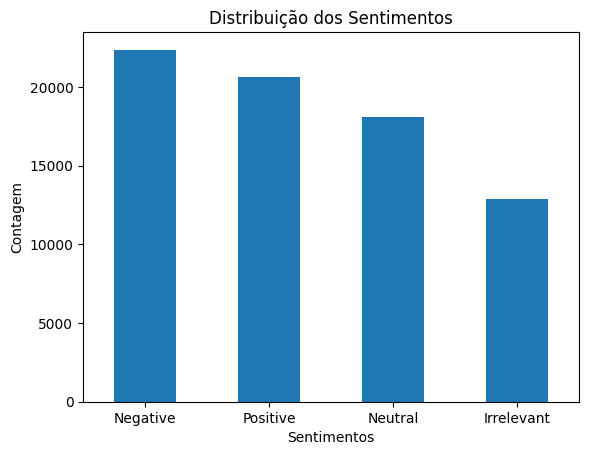

In [11]:
value_counts = df["sentiment"].value_counts()
ax = value_counts.plot(kind='bar')

ax.set_xticklabels(['Negative', 'Positive', 'Neutral', 'Irrelevant'], rotation=0)

plt.title('Distribuição dos Sentimentos')
plt.xlabel('Sentimentos')
plt.ylabel('Contagem')

plt.show()

In [12]:
nltk.download('wordnet')
nltk.download('stopwords')
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocessing_text(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = text.split()
    text = " ".join([wnl.lemmatize(word) for word in text if not word in stop_words and len(word) >= 3])
    return text.lower()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\janna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
print(preprocessing_text("im getting on borderlands and i will murder you"))

getting borderland murder


In [14]:
df["content"] = df["content"].apply(preprocessing_text)

In [15]:
df.head()

,sentiment,content,label_sentiment
0,Positive,getting borderland murder,3
1,Positive,coming border kill,3
2,Positive,getting borderland kill,3
3,Positive,coming borderland murder,3
4,Positive,getting borderland murder,3


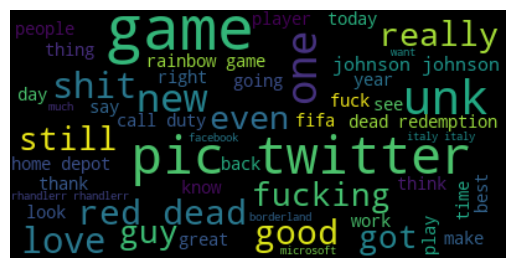

In [16]:
from PIL import Image
from wordcloud import WordCloud

text = " ".join(df["content"])

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="blacK").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
from random import randint

x = randint(0, df.shape[0])

df.iloc[x:x+5, :]

,sentiment,content,label_sentiment
6262,Neutral,are making amazon seller find cheaper way stop...,2
6263,Neutral,are amazon seller find way stop throwing away ...,2
6264,Neutral,fast paced engaging one kind read grab copy mu...,2
6265,Neutral,fast paced riveting unique read grab copy murd...,2
6266,Neutral,fast exciting unique take copy murder preacher,2


### Modeling

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [19]:
def get_vocab(X):
    vocab = {'__UNK__': 0}

    for item in X:
        for word in item.split():
            if word not in vocab:
                vocab[word] = len(vocab)
    
    return vocab

vocab = get_vocab(df["content"])

In [20]:
print(len(vocab))

27371


In [21]:
def text_to_tensor(text, unk_token='__UNK__'):
    
    tensor = [0] * 130

    for e, word in enumerate(text.split()):
        if not word in vocab:
            word = unk_token
        
        tensor[e] = vocab[word]
    
    return tensor

In [22]:
m = 0

list_x = df["content"].values

for i in range(df["content"].shape[0]):
    if len(text_to_tensor(list_x[i])) > m:
        m = len(text_to_tensor(list_x[i]))

print(m)

130


In [23]:
X = list(df["content"].apply(text_to_tensor))
y = list(df["label_sentiment"])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
X_train = torch.as_tensor(X_train).to(device)
y_train = torch.as_tensor(y_train).to(device)

In [40]:
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

In [88]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("train_data length:", len(train_data))

X_train shape: torch.Size([59196, 130])
y_train shape: torch.Size([59196])
train_data length: 59196


### Model 1

In [96]:
class SimpleNLPModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(SimpleNLPModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = torch.mean(embedded, dim=1)
        out = self.fc(pooled)
        return out

In [98]:
vocab_size = len(vocab) + 1
embed_size = 10
num_classes = df["sentiment"].nunique()

In [99]:
model = SimpleNLPModel(vocab_size, embed_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [102]:
num_epochs = 20
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    train_loss.append(loss.item())
    train_accuracy.append(accuracy * 100)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20, Loss: 0.012774219736456871, Accuracy: 90.63%
Epoch 2/20, Loss: 0.09695367515087128, Accuracy: 90.72%
Epoch 3/20, Loss: 1.2053179740905762, Accuracy: 90.80%
Epoch 4/20, Loss: 0.9564710259437561, Accuracy: 90.83%
Epoch 5/20, Loss: 0.3209918439388275, Accuracy: 90.89%
Epoch 6/20, Loss: 0.0092769181355834, Accuracy: 90.87%
Epoch 7/20, Loss: 0.0741775706410408, Accuracy: 91.06%
Epoch 8/20, Loss: 0.3898705244064331, Accuracy: 91.09%
Epoch 9/20, Loss: 0.08352857083082199, Accuracy: 91.02%
Epoch 10/20, Loss: 0.00015751097816973925, Accuracy: 91.07%
Epoch 11/20, Loss: 0.0008896802901290357, Accuracy: 91.19%
Epoch 12/20, Loss: 0.6245195269584656, Accuracy: 91.19%
Epoch 13/20, Loss: 0.0061994437128305435, Accuracy: 91.23%
Epoch 14/20, Loss: 0.021931074559688568, Accuracy: 91.15%
Epoch 15/20, Loss: 0.8644542098045349, Accuracy: 91.34%
Epoch 16/20, Loss: 0.32188594341278076, Accuracy: 91.22%
Epoch 17/20, Loss: 0.006121572107076645, Accuracy: 91.35%
Epoch 18/20, Loss: 0.0802527442574501,

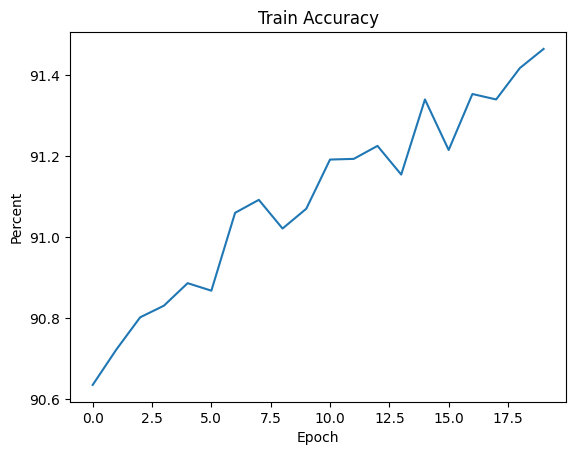

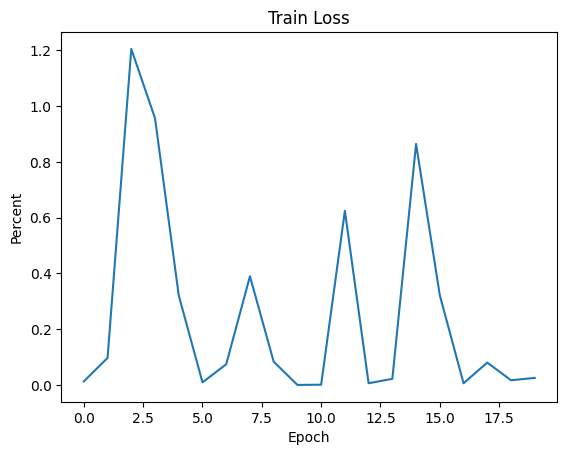

In [107]:
plt.plot(train_accuracy)
plt.ylabel("Percent")
plt.xlabel("Epoch")
plt.title("Train Accuracy")
plt.show()

plt.plot(train_loss)
plt.ylabel("Percent")
plt.xlabel("Epoch")
plt.title("Train Loss")
plt.show()

### Model 2

In [170]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = torch.mean(embedded, dim=1)
        pooled = pooled.unsqueeze(0)
        output, _ = self.lstm(pooled)
        output = self.fc(output.squeeze(0))
        return output


In [171]:
vocab_size = len(vocab) + 1
embed_size = 130
num_classes = df["sentiment"].nunique()
hidden_size = 10
num_layers = 2
dropout = 0.2

In [172]:
model = LSTMModel(vocab_size, embed_size, num_classes, hidden_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [173]:
num_epochs = 20
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    train_loss.append(loss.item())
    train_accuracy.append(accuracy * 100)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20, Loss: 1.1165246963500977, Accuracy: 38.07%
Epoch 2/20, Loss: 0.42907100915908813, Accuracy: 50.45%
Epoch 3/20, Loss: 0.9377549290657043, Accuracy: 59.21%
Epoch 4/20, Loss: 0.34638309478759766, Accuracy: 64.26%
Epoch 5/20, Loss: 0.3733101189136505, Accuracy: 69.48%
Epoch 6/20, Loss: 0.0632098987698555, Accuracy: 74.14%
Epoch 7/20, Loss: 0.017795074731111526, Accuracy: 78.09%
Epoch 8/20, Loss: 0.14468567073345184, Accuracy: 80.95%
Epoch 9/20, Loss: 0.02278321608901024, Accuracy: 82.91%
Epoch 10/20, Loss: 1.637899398803711, Accuracy: 84.37%
Epoch 11/20, Loss: 0.782002329826355, Accuracy: 85.78%
Epoch 12/20, Loss: 0.17902764678001404, Accuracy: 86.83%
Epoch 13/20, Loss: 0.2775728404521942, Accuracy: 87.44%
Epoch 14/20, Loss: 0.0002323088701814413, Accuracy: 88.20%
Epoch 15/20, Loss: 0.10764028131961823, Accuracy: 88.68%
Epoch 16/20, Loss: 0.24809607863426208, Accuracy: 89.20%
Epoch 17/20, Loss: 0.001185034867376089, Accuracy: 89.58%
Epoch 18/20, Loss: 1.175993800163269, Accurac